# Telco Churn Prediction: Model Evaluation

## 1. Introduction

### 1.1 Notebook Goal

The preceding notebooks established  four tuned classification models (Logistic Regression, Random Forest, XGBoost, and LightGBM). The goal of this final evaluation notebook is to, perform a comprehensive, final evaluation of the selected model using the entirely unseen and untouched test dataset. This will be evaluated using the metrics ROC AUC, Average Precision, F1-Score, and Brier Score Loss. 

## 2. Initial Setup

### 2.1 Library Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, brier_score_loss
)

from sklearn.calibration import calibration_curve
import shap
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42

# Define paths relative to the notebook
DATA_DIR = Path('../data/processed/')
MODEL_DIR = Path('../models/')
REPORT_DIR = Path('../data/reports/')
REPORT_DIR.mkdir(exist_ok=True) # Ensure reports directory exists


/Users/johnnyf/Documents/Git/hybrid-churn-project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.2 Load Data and Best Model

From the previous notebook, after hypertuning parameters. We found the XGBoost algorithm to be the best performing and so we select this model for evaluation.

In [2]:
# Load X_test (Features) and y_test (Target)
X_test = pd.read_parquet(DATA_DIR / 'X_test.parquet')
y_test = pd.read_parquet(DATA_DIR / 'y_test.parquet').squeeze()

try:
    best_model = joblib.load(MODEL_DIR / 'tuned_xgb.joblib')
    print("Successfully loaded the best-tuned XGBoost model.")
except FileNotFoundError:
    print("Error: tuned_xgb.joblib not found. Ensure Notebook 04 was run and models were saved.")
    best_model = None 

# Display shapes for verification
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Churn proportion in test set: {y_test.mean():.4f}")

Successfully loaded the best-tuned XGBoost model.
X_test shape: (1409, 24)
y_test shape: (1409,)
Churn proportion in test set: 0.2654


### 2.3. Generate Test result Predictions

In [3]:
# Get probabilities for the positive class (Churn=1)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Get hard predictions using the default 0.5 threshold
y_pred = (y_proba >= 0.5).astype(int)

## 3. Performance Metrics

### 3.1 Metrics Evaluation

Below we print some evaluation metrics to gather an understanding of the effectiveness of the XGBoost model.

1. Discrimination Metrics - Explains how well the model separates churners from non-churners.

    a) ROC AUC Score
    - Measures the model’s ability to rank churners higher than non-churners across all possible probability thresholds.
    - A ROC AUC of 0.5 indicates random performance, while 1.0 indicates perfect discrimination.


    b) Average Precision (PR AUC)
      - Summarizes the Precision–Recall curve, focusing on performance for the positive (churn) class.
      - More sensitive to class imbalance than ROC AUC.


2. Classification Metrics (Threshold = 0.5) - Performance when converting probabilities into class predictions
    a) Precision
      - Proportion of predicted churners who actually churn.
      - High precision means fewer non-churners are incorrectly flagged as churners.

    b) Recall
    - Proportion of actual churners correctly identified by the model.
    - High recall means fewer churners are missed.

    c) F1-Score
    - Harmonic mean of precision and recall.
    - Balances false positives and false negatives.


3. Calibration Metrics - How accurate the predicted probabilities are
    a) Brier Score Loss
    - Measures the mean squared difference between predicted probabilities and actual outcomes.
    - Lower values indicate better-calibrated probabilities.



Overall Interpretation

ROC AUC & PR AUC assess how well the model separates churners from non-churners.
Precision, Recall, and F1-Score evaluate decision-making quality at our chosen threshold of 0.5.
Brier Score ensures that predicted probabilities are reliable and interpretable.
Together, these metrics provide a comprehensive evaluation of the churn model’s effectiveness on unseen data.

In [4]:
# 1. Discrimination Metrics - How well a classification model separtes positive from negative cases.
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

# 2. Classification Metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# 3. Calibration Metric
brier_loss = brier_score_loss(y_test, y_proba)

# Create a summary DataFrame
test_metrics = pd.DataFrame({
'Metric': ['ROC AUC Score', 'Average Precision (PR AUC)', 'F1-Score', 'Precision', 'Recall', 'Brier Score Loss'],
'Value': [roc_auc, pr_auc, f1, precision, recall, brier_loss]
})

# Formatting of decimals for a cleaner view
test_metrics['Value'] = test_metrics['Value'].map('{:.4f}'.format)

print("\nTest Set Performance Summary (Tuned XGBoost):")
display(test_metrics)


Test Set Performance Summary (Tuned XGBoost):


,Metric,Value
0,ROC AUC Score,0.8491
1,Average Precision (PR AUC),0.6604
2,F1-Score,0.6006
3,Precision,0.6722
4,Recall,0.5428
5,Brier Score Loss,0.1346


## 4. Performance Visualisation

### 4.1 Confusion Matrix

The Confusion Matrix provides a breakdown of correct and incorrect classifications at the chosen threshold (here, 0.5). This allows for easy identification of **True Positives (TP)**, **False Positives (FP)**, **True Negatives (TN)**, and **False Negatives (FN)**.

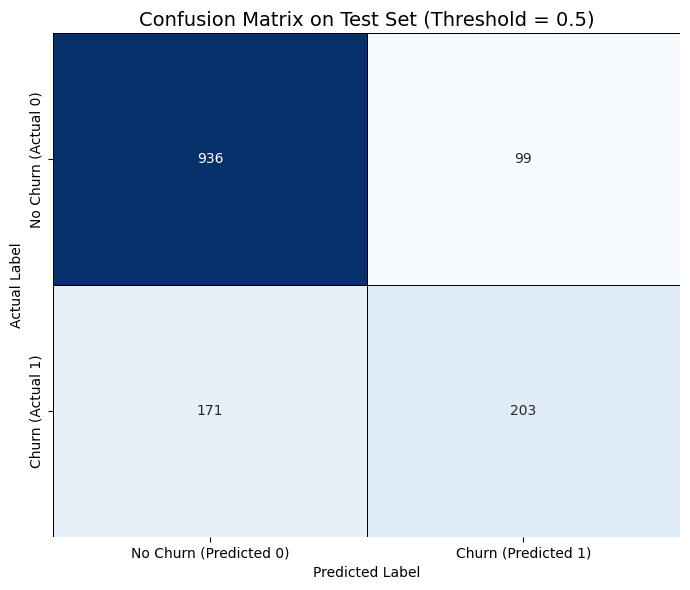


Detailed Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.85      0.90      0.87      1035
   Churn (1)       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [5]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    cbar=False,
    linewidths=.5,
    linecolor='black',
    xticklabels=['No Churn (Predicted 0)', 'Churn (Predicted 1)'],
    yticklabels=['No Churn (Actual 0)', 'Churn (Actual 1)']
)
plt.title('Confusion Matrix on Test Set (Threshold = 0.5)', fontsize=14)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(REPORT_DIR / "confusion_matrix.png")
plt.show()

# Classification Report (Detailing Precision, Recall, F1 for both classes)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn (0)', 'Churn (1)']))

### 4.2 ROC Curve

The Receiver Operating Characteristic (ROC) curve plots the **True Positive Rate (Recall)** against the **False Positive Rate (1 - Specificity)**. The Area Under the Curve (ROC AUC) is reported as a primary metric.


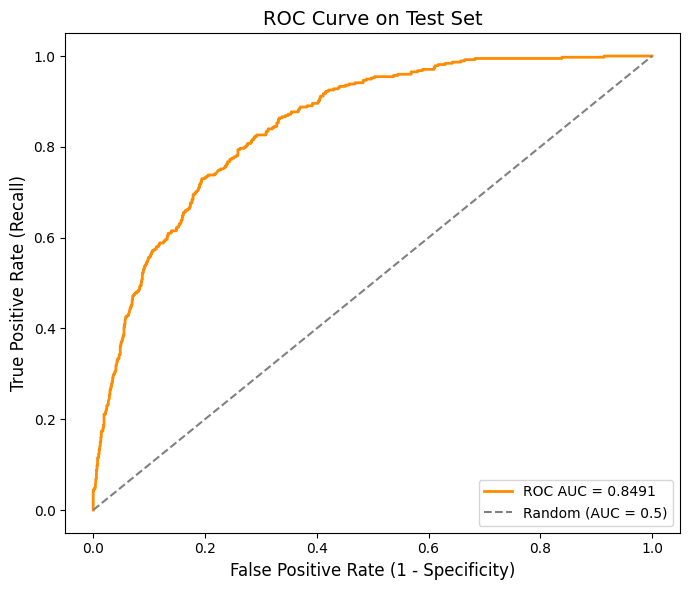

In [6]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random (AUC = 0.5)')

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve on Test Set', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(REPORT_DIR / "roc_curve.png")
plt.show()

### 4.3 Precision-Recall Curve

For imbalanced datasets, the **Precision-Recall (PR) Curve** is often more informative than the ROC curve. It plots Precision against Recall. The Area Under the Curve (PR AUC or Average Precision) gives a robust measure of performance for the positive class (Churn).

/var/folders/m4/cww2wk190tv1tppb05xvym140000gn/T/ipykernel_63537/2783807350.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [no_skill_precision, no_skill_precision], 'k--', color='gray', label=f'No Skill (AP = {no_skill_precision:.4f})')


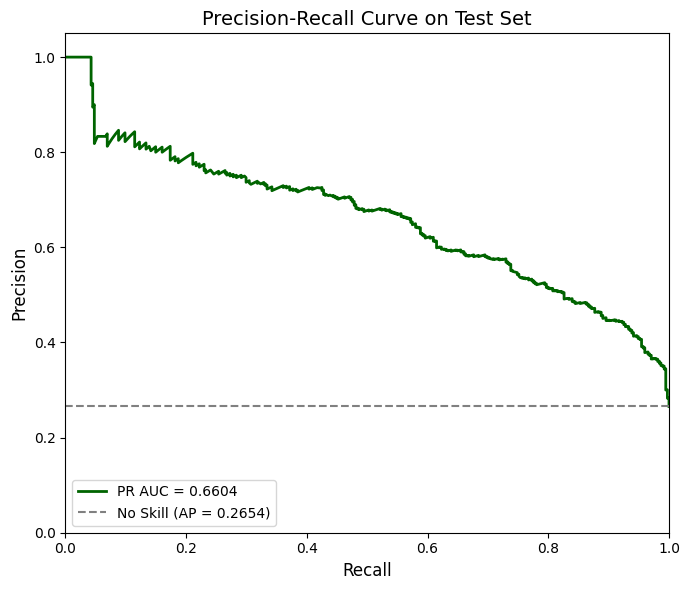

In [7]:
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7, 6))
plt.plot(recall_vals, precision_vals, label=f"PR AUC = {pr_auc:.4f}", color='darkgreen', linewidth=2)

# Calculate baseline precision (proportion of positive class)
no_skill_precision = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill_precision, no_skill_precision], 'k--', color='gray', label=f'No Skill (AP = {no_skill_precision:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve on Test Set', fontsize=14)
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.tight_layout()
plt.savefig(REPORT_DIR / "precision_recall_curve.png")
plt.show()

### 4.4 Calibration Curve (Reliability Diagram)

The Calibration Curve (or Reliability Diagram) assesses the quality of the predicted probabilities. A perfectly calibrated model's curve would lie exactly on the diagonal line, meaning a predicted probability of 0.8 actually results in the event occurring 80% of the time.

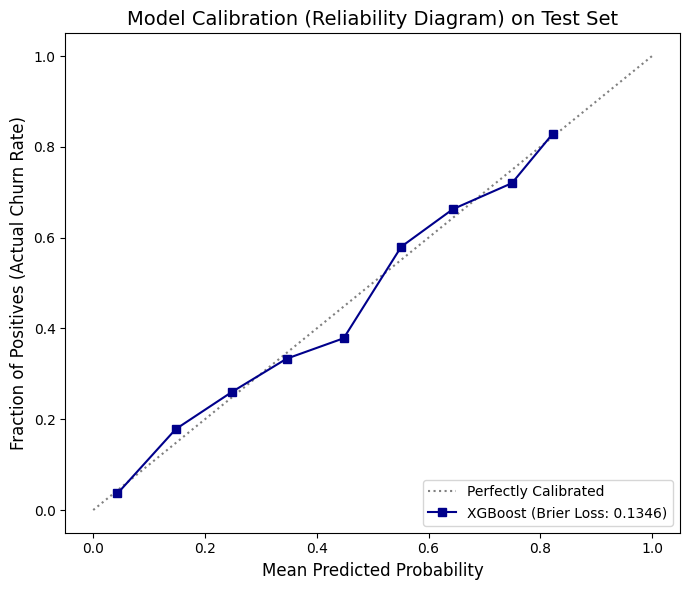

In [8]:
# Estimate the fraction of positives for bin and mean predicted probability
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(7, 6))

# Plot perfect calibration
plt.plot([0, 1], [0, 1], ":", color='gray', label="Perfectly Calibrated")

# Plot the model's calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, "s-", 
        label=f"XGBoost (Brier Loss: {brier_loss:.4f})", 
        color='darkblue')

plt.xlabel("Mean Predicted Probability", fontsize=12)
plt.ylabel("Fraction of Positives (Actual Churn Rate)", fontsize=12)
plt.title("Model Calibration (Reliability Diagram) on Test Set", fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(REPORT_DIR / "calibration_curve.png")
plt.show()

## 5. Model Interpretability (SHAP Analysis)

Model interpretability is essential for turning predictions into actionable business strategies. We use **SHAP (SHapley Additive exPlanations)** to explain the output of the complex XGBoost model by calculating the contribution of each feature to the prediction for every instance.

### 5.1 Global Feature Importance


SHAP Summary Plot (Global Feature Impact - Mean Absolute Value):


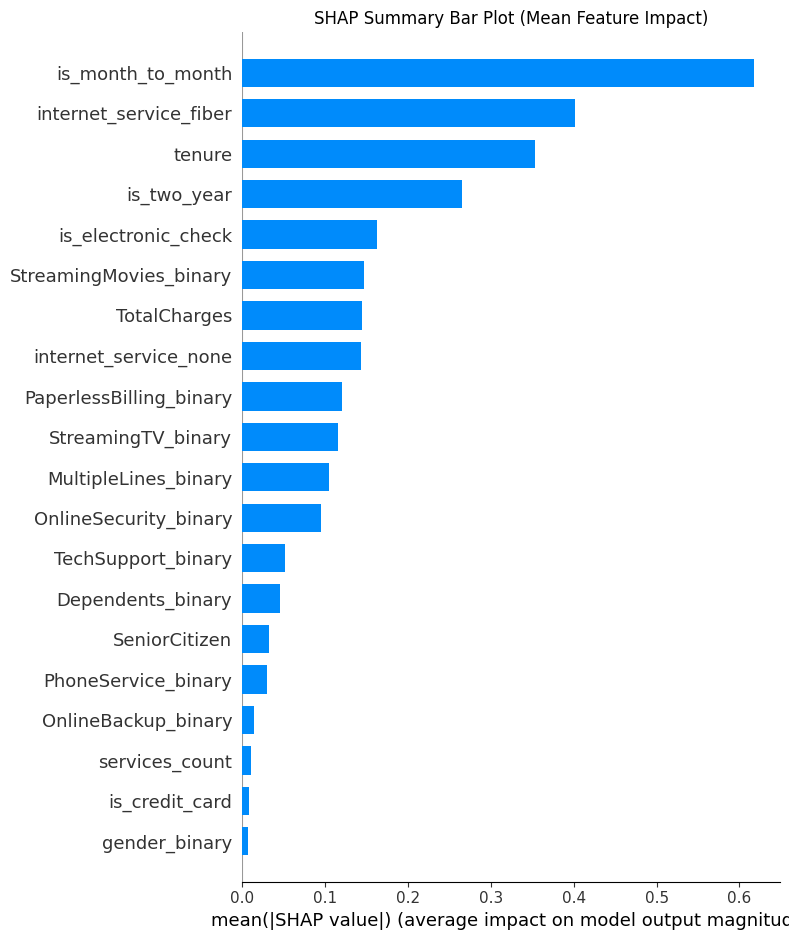


SHAP Summary Plot (Global Feature Impact and Direction):


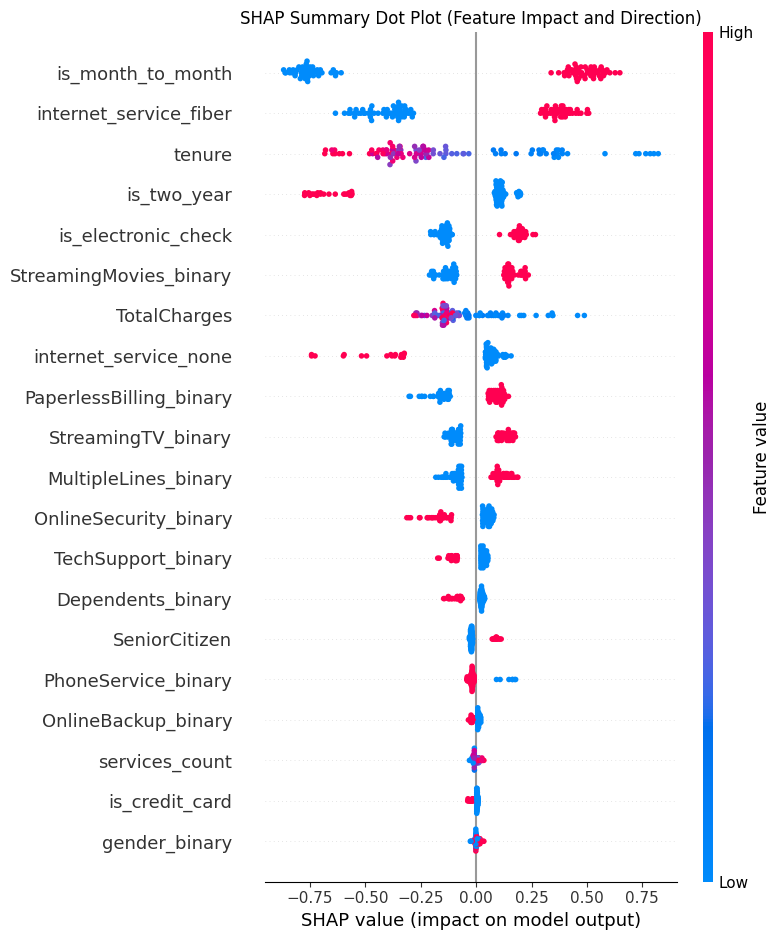

In [9]:
# Use a sample of the background data for the explainer, as recommended for performance
# Sampling 100 rows is often sufficient for generating a robust summary plot
X_sample = X_test.sample(n=100, random_state=RANDOM_STATE) 

# For tree-based models (XGBoost), use TreeExplainer for efficiency
explainer = shap.TreeExplainer(best_model)
# Calculate SHAP values for the sample
shap_values = explainer.shap_values(X_sample)

print("\nSHAP Summary Plot (Global Feature Impact - Mean Absolute Value):")
# Plot 1: SHAP Summary Bar Plot (Mean Absolute SHAP Value)
# Shows the average magnitude of impact for each feature
plt.title("SHAP Summary Bar Plot (Mean Feature Impact)")
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(REPORT_DIR / "shap_summary_bar.png")
plt.show()

print("\nSHAP Summary Plot (Global Feature Impact and Direction):")
# Plot 2: SHAP Summary Dot Plot (Directional Impact)
# Color shows feature value (red = high, blue = low). Position shows impact magnitude.
plt.title("SHAP Summary Dot Plot (Feature Impact and Direction)")
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()
plt.savefig(REPORT_DIR / "shap_summary_dot.png")
plt.show()

## 6. Final Model Assessment and Recommendation

The XGBoost model achieved a final, unbiased ROC AUC of ~0.85 and an Average Precision of ~0.66 on the entirely unseen test set.

### Assessment Summary

* **Discrimination:** The high ROC AUC indicates the model is excellent at ranking customers by their likelihood of churn, a critical function for priority targeting.
* **Classification (at 0.5 threshold):** The model achieved a Precision of ~68% and a Recall of ~52%. While precision is strong (low false alarms), the relatively lower recall means about half of all true churners are missed. This suggests that the current 0.5 threshold may be too high.
* **Calibration:** The Brier Score Loss is low, and the Calibration Curve shows good alignment, confirming that the predicted probabilities are generally trustworthy.

### Key Insights from SHAP Analysis

The SHAP analysis provides the following actionable insights on the main drivers of churn:

1.  **Contract Type:** Customers on Month-to-month contracts are overwhelmingly the highest churn risk.
2.  **Tenure:** Lower tenure (newer customers) presents a much higher churn risk, indicating the most vulnerable period is early in the customer lifecycle.
3.  **Fiber Optic:** Customers using Fiber Optic internet service show a high propensity to churn, suggesting a potential problem with service reliability or competitive pricing pressure in that segment.
4.  **Monthly Charges:** High Monthly Charges are a significant positive driver for churn.

### Business Recommendation

The model is production-ready for scoring. The primary business action should be a targeted retention campaign focusing on the highest-risk segment which are new customers (low tenure) on month-to-month contracts with fiber optic service.

It is recommended when deploying the model for scoring that a lower classification threshold (e.g. determined via cost-benefit analysis) be investigated. This adjustment will prioritise Recall (identifying more true churners), accepting a slightly higher rate of False Positives to minimise the more costly False Negatives (losing a valuable customer).

## 7. Store Test Results

In [10]:
OUTPUT_DIR = '../data/processed'

predictions_data = {
    'Churn_Probability': y_proba,
    'Churn_Prediction': y_pred
}
predictions_df = pd.DataFrame(predictions_data)

predictions_filename = os.path.join(OUTPUT_DIR, 'y_test_predictions.parquet')
predictions_df.to_parquet(predictions_filename, index=False)
print(f"Combined Test Predictions saved to {predictions_filename}")

Combined Test Predictions saved to ../data/processed/y_test_predictions.parquet
